In [1]:
# load model
import torch
from models.improved_ddpm.script_util import i_DDPM

device = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")
# device = torch.device("cpu")
print(device)

model = i_DDPM("IMAGENET") # imagenet
learn_sigma = True
ckpt = torch.load("./512x512_diffusion.pt")
model.load_state_dict(ckpt)
model.to(device)
# model = torch.nn.DataParallel(model)
model.eval()
print("Improved diffusion Model loaded.")

cuda:1
Improved diffusion Model loaded.


In [2]:
n_inv_step = 40
n_test_step = 40
t_0  = 601

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image

def show_image(x):
    x = (x + 1) * 0.5
    tensor_cpu = x.cpu()
    image = tensor_cpu.squeeze(0).permute(1, 2, 0).numpy()
    plt.imshow(image,cmap='gray')
    plt.axis('off')
    plt.show()

def luma_transform(input):
    assert input.shape[1] == 3, "Input must have 3 channels"
    R, G, B = input[:, 0, :, :], input[:, 1, :, :], input[:, 2, :, :]
    L = R * 0.299 + G * 0.587 + B * 0.114
    L = L.unsqueeze(1).expand(-1, 3, -1, -1)
    return L

success
torch.Size([1, 3, 512, 512])
cuda:1


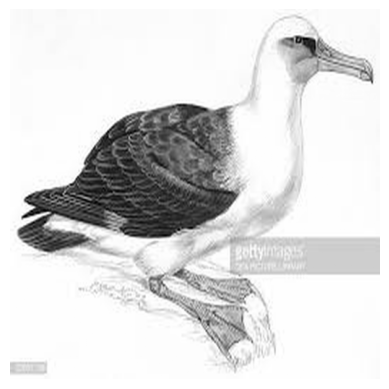

In [4]:
from diffusion_utils import get_beta_schedule,denoising_step
from PIL import Image
import torch
from tqdm import tqdm

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

class config: 
    class diffusion:
        beta_schedule = "linear"
        beta_start = 0.0001
        beta_end = 0.02
        num_diffusion_timesteps = 1000

betas = get_beta_schedule(
            beta_start=config.diffusion.beta_start,
            beta_end=config.diffusion.beta_end,
            num_diffusion_timesteps=config.diffusion.num_diffusion_timesteps
        )

alphas = 1.0 - betas
alphas_cumprod = np.cumprod(alphas, axis=0)
alphas_cumprod_prev = np.append(1.0, alphas_cumprod[:-1])
posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)

betas = torch.from_numpy(betas).float().to(device)

logvar = np.log(np.maximum(posterior_variance, 1e-20))

# X0 image preprocess
img = Image.open("../data/CUB-200-Painting/002.Laysan_Albatross/Laysan_Albatross_0.jpg").convert("RGB")
img = img.resize((512,512), Image.ANTIALIAS)
img = np.array(img) / 255
img = torch.from_numpy(img).type(torch.FloatTensor).permute(2,0,1).unsqueeze(dim=0)
img = img.to(device)
x0 = (img - 0.5) * 2

x0 = luma_transform(x0)

print("success")
print(x0.shape)
print(device)
show_image(x0)

Inversion process :   0%|          | 0/40 [00:00<?, ?it/s]/home/h3c/wsj/content/LADS/test_diffusion/diffusion_utils.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = torch.gather(torch.tensor(a, dtype=torch.float, device=t.device), 0, t.long())
Inversion process :  98%|█████████▊| 39/40 [00:11<00:00,  3.53it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 512, 512])


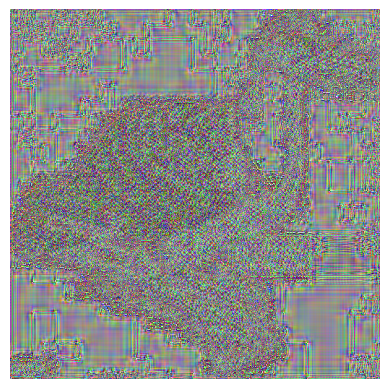

In [5]:
with torch.no_grad():
    seq_inv = np.linspace(0, 1, n_inv_step) * t_0
    seq_inv = [int(s) for s in list(seq_inv)]
    seq_inv_next = [-1] + list(seq_inv[:-1])

    x = x0.clone()
    with tqdm(total=len(seq_inv), desc=f"Inversion process ") as progress_bar:
        for it, (i, j) in enumerate(zip((seq_inv_next[1:]), (seq_inv[1:]))):
            t = (torch.ones(1) * i).to(device)
            t_prev = (torch.ones(1) * j).to(device)
            x = denoising_step(
                x, t=t, t_next=t_prev, models=model, 
                logvars=logvar, sampling_type='ddim', 
                b=betas, eta=0, learn_sigma=learn_sigma, 
                ratio=0,
                )

            progress_bar.update(1)
        x_lat = x.clone()

print(x_lat.shape)
show_image(x_lat)

Sampling type: DDIM with eta 0.0,  Steps: 40/601


Generative process 4: 100%|██████████| 40/40 [00:10<00:00,  3.98it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 512, 512])


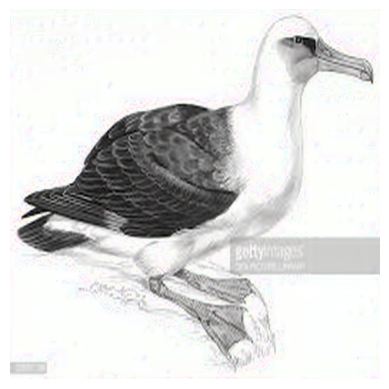

In [6]:
with torch.no_grad():
    print(f"Sampling type: {'ddim'.upper()} with eta {0.0}, "
            f" Steps: {n_test_step}/{t_0}")
    seq_test = np.linspace(0, 1, n_test_step) * t_0
    seq_test = [int(s) for s in list(seq_test)]
    seq_test_next = [-1] + list(seq_test[:-1])

    n_iter = 5
    for it in range(n_iter):
        x = x_lat.clone()
        with tqdm(total=len(seq_test), desc="Generative process {}".format(it)) as progress_bar:
            for i, j in zip(reversed(seq_test), reversed(seq_test_next)):
                t = (torch.ones(1) * i).to(device)
                t_next = (torch.ones(1) * j).to(device)
                x = denoising_step(x, t=t, t_next=t_next, models=model,
                                           logvars=logvar,
                                           sampling_type='ddim',
                                           b=betas,
                                           eta=0.0,
                                           learn_sigma=learn_sigma,
                                           ratio=0,
                                           )
                
                progress_bar.update(1)

print(x.shape)
show_image(x)

In [ ]:
# n_iter = 5
# with torch.no_grad():
#     for it in range(1):
#         print("**********************x0**********************")
#         show_image(x0)
#         e = torch.randn_like(x0)
#         a = (1 - betas).cumprod(dim=0)
#         x = x0 * a[t_0 - 1].sqrt() + e * (1.0 - a[t_0 - 1]).sqrt()
#         print("**********************noise added**********************")
#         show_image(x)
        
#         with tqdm(total=len(seq_inv), desc=f"Inversion process ") as progress_bar:
#             for item, (i, j) in enumerate(zip(reversed(seq_inv), reversed(seq_inv_next))):
#             # for item, (i, j) in enumerate(zip((seq_inv_next[1:]), (seq_inv[1:]))):
#                 t = (torch.ones(1) * i).to(device)
#                 t_prev = (torch.ones(1) * j).to(device)

#                 x = denoising_step(
#                     x, t=t, t_next=t_prev, models=model, logvars=logvar, 
#                     sampling_type='ddim', b=betas, eta=0, 
#                     learn_sigma=learn_sigma
#                 )

#                 progress_bar.update(1)
        
#         print("**********************reversed!**********************")
#         show_image(x)       
#         x0 = x.clone()


# print("success")

In [ ]:
# import torch
# from PIL import Image
# import numpy as np

# def luma_transform(input):
#     assert input.shape[1] == 3, "Input must have 3 channels"
#     R, G, B = input[:, 0, :, :], input[:, 1, :, :], input[:, 2, :, :]
#     L = R * 0.299 + G * 0.587 + B * 0.114
#     L = L.unsqueeze(1).expand(-1, 3, -1, -1)
#     return L


# img = Image.open("../data/CUB-200-Painting/002.Laysan_Albatross/Laysan_Albatross_0.jpg").convert("RGB")
# img = img.resize((512,512), Image.ANTIALIAS)
# img = np.array(img) / 255
# img = torch.from_numpy(img).type(torch.FloatTensor).permute(2,0,1).unsqueeze(dim=0)
# x0 = (img - 0.5) * 2

# show_image(x0)
# print(x0.shape)

# x1=luma_transform(x0)
# show_image(x1)
# print(x1.shape)